In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value

In [2]:

second_TGCNN_layer = True
demo = True


stride = 1
filter_size = 4
num_filters = 16
years_in_advance = '5'
hip_or_knee='hip'
max_timesteps=100
include_drugs = True
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512

# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=num_filters, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=stride, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

# Load in the filters from the model
with open('hip_1999_to_one_year_advance_model1_filter.npy', 'rb') as f:
    filters = np.load(f)


normalised gamma [[0.00970072]]
normalised gamma [[0.00609771]]


### Get the violin plots to show maximum activation difference

In [8]:
num_patients = 10

pat_df = create_fake_patients.create_fake_patient_df(num_patients=num_patients, max_events=max_timesteps-1, max_nodes=max_event_codes)

replacement_true_lst = []
max_w_filt_lst = []
filt_nums = list(range(1, num_filters+1))  # Since filt_nums is always 1 to num_filters for each patient

for i in range(num_patients):
    input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_pat_from_df(pat_df, max_event_codes, hip_or_knee, i)
    
    dense_tensor = tf.sparse.to_dense(input_3d)
    dense_tensor = tf.transpose(dense_tensor, perm=[2, 1, 0])
    dense_tensor = tf.reverse(dense_tensor, axis=[0])
    
    logits = model(input_4d, demo_tensor, training=False)
    
    feature_maps = model.f_map_branch1
    
    # Get the maximum value from each filter and apply ReLU
    max_w_per_filt = tf.reduce_max(feature_maps, axis=2)
    max_w_per_filt_relu = tf.nn.relu(max_w_per_filt)
    
    # Convert to list and extend results directly
    max_w_per_filt_relu_np = max_w_per_filt_relu.numpy().flatten().tolist()
    
    replacement_true_lst.extend([outcome_bin] * num_filters)
    max_w_filt_lst.extend(max_w_per_filt_relu_np)

# filt_nums list should be extended `num_patients` times.
filt_nums = filt_nums * num_patients

# print(replacement_true_lst)
# print(max_w_filt_lst)
# print(filt_nums)


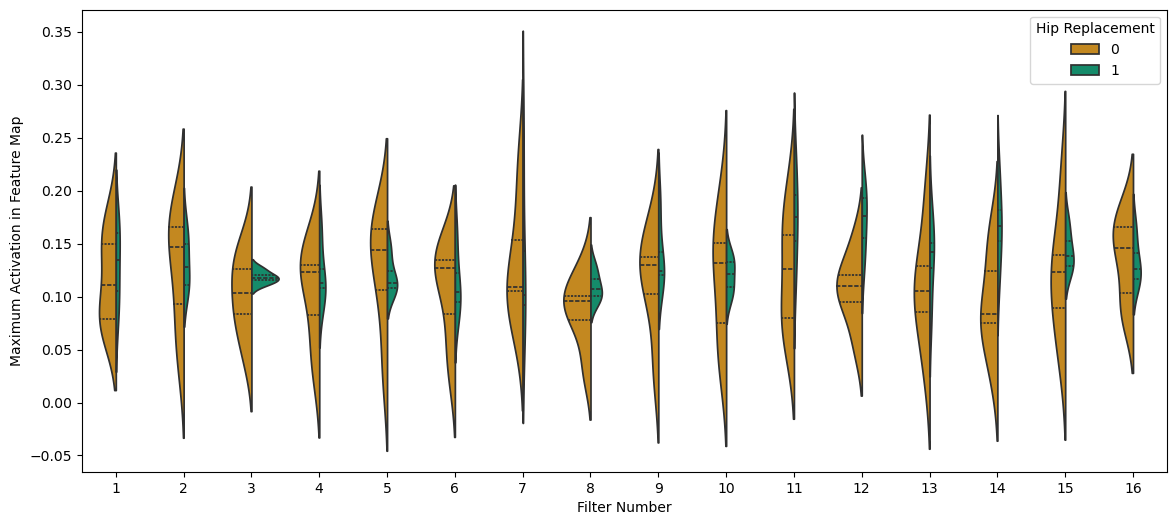

In [9]:
plot_feature_value.violin_plots(filt_nums, max_w_filt_lst, replacement_true_lst)

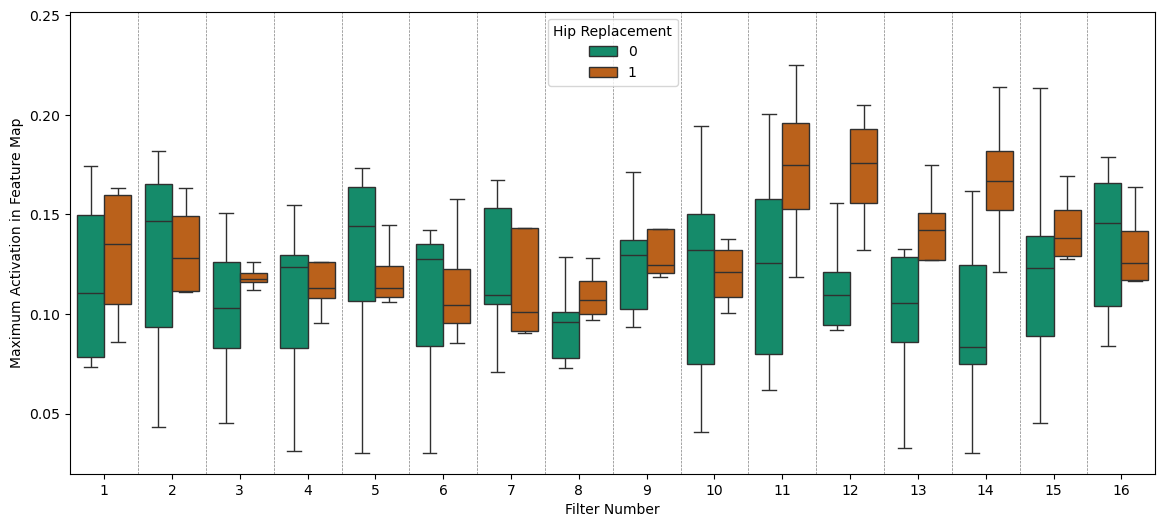

In [10]:
plot_feature_value.max_act_box_plots(filt_nums, max_w_filt_lst, replacement_true_lst)

### Calculate the strongest difference between the patient and control participants

In [11]:
# Create a dictionary with your lists
data = {
    'Hip Replacement': replacement_true_lst,
    'Max Activation': max_w_filt_lst,
    'Filter': filt_nums
}

filt_act_df = pd.DataFrame(data)

In [16]:
mean_activation = filt_act_df.groupby(['Filter', 'Hip Replacement'])['Max Activation'].mean()

mean_activation_df = mean_activation.to_frame()
mean_activation_df.reset_index(inplace=True)

# Calculate the difference between the two Hip Replacement rows for each Filter
mean_activation_df['Difference'] = mean_activation_df.groupby('Filter')['Max Activation'].diff()
mean_activation_df['Difference'] = mean_activation_df['Difference'].abs()

mean_activation_df = mean_activation_df[['Filter', 'Difference']].dropna().reset_index(drop=True)

mean_activation_df.sort_values(by='Difference', ascending=False)

,Filter,Difference
13,14,0.072353
11,12,0.065070
10,11,0.048866
12,13,0.026410
8,9,0.022890
7,8,0.022336
14,15,0.022125
2,3,0.016413
3,4,0.015196
0,1,0.013133


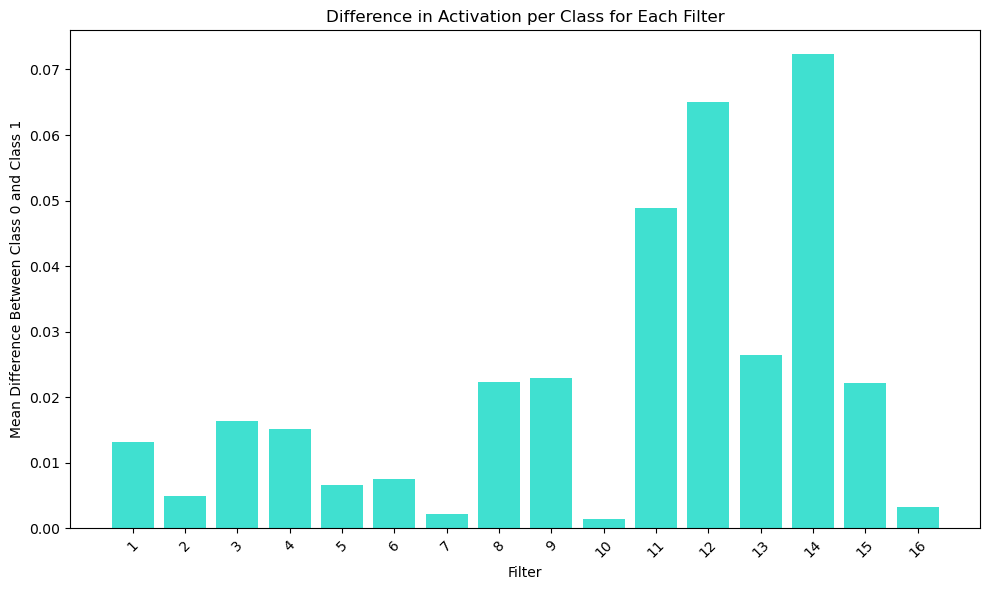

In [17]:
mean_activation_df['Filter'] = mean_activation_df['Filter'].astype(int)

# Plotting the line chart
plt.figure(figsize=(10, 6))
#plt.plot(mean_activation_df['Filter'], mean_activation_df['Difference'], marker='.', linestyle='-')
plt.bar(mean_activation_df['Filter'], mean_activation_df['Difference'], color='turquoise')
plt.xlabel('Filter')
plt.ylabel('Mean Difference Between Class 0 and Class 1')
plt.title('Difference in Activation per Class for Each Filter')
plt.xticks(mean_activation_df['Filter'], rotation=45)  # Set x-axis ticks to integer values with rotation
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()